In [133]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials

from array import array
import os
from PIL import Image
import sys
import time

'''
Authenticate
Authenticates your credentials and creates a client.
'''
subscription_key = os.environ["VISION_KEY"]
endpoint = os.environ["VISION_ENDPOINT"]

computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))

In [134]:
'''
    Levenshtein distance
    :param a: string, string to compare
    :param b: string, string to compare

    returns the Levenshtein distance between the strings
'''
def lev_distance(a, b):
    if len(a) < len(b):
        return lev_distance(b, a)

    if len(b) == 0:
        return len(a)

    previous_row = range(len(b) + 1)
    for i, c1 in enumerate(a):
        current_row = [i + 1]
        for j, c2 in enumerate(b):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row

    return previous_row[-1]

In [135]:
from math import floor

'''
    Computes the jaro distance
    :param a: string, result
    :param b: string, expected

    returns jaro distance
'''
def jaro_distance(a, b) :
	if a == b:
		return 0
 
	lenA = len(a)
	lenB = len(b) 

	if lenA == 0 or lenB == 0:
		return 0 

	delta = (max(len(a), len(b)) // 2 ) - 1

	match = 0 

	hashA = [0] * len(a) 
	hashB = [0] * len(b) 

	for i in range(lenA) : 
		for j in range(max(0, i - delta), 
					min(lenB, i + delta + 1)): 
			
			if a[i] == b[j] and hashB[j] == 0: 
				hashA[i] = 1
				hashB[j] = 1 
				match += 1
				break
		
	if match == 0:
		return 0
	
	t = 0
	point = 0

	for i in range(lenA): 
		if hashA[i]:
			while hashB[point] == 0:
				point += 1

			if a[i] != b[point]:
				point += 1
				t += 1
			else:
				point += 1
				
		t /= 2

	return lenB - match


In [136]:
'''
    Char error rate
    :param result: list of strings, resulted from OCR
    :param truth: list of strings, the true values

    returns cer
'''
def cer(result, truth, metric):
    total = sum(len(line) for line in truth)
    dist = sum(metric(actual_line, expected_line)
                               for actual_line, expected_line
                               in zip(result, truth))
    return dist / total

'''
    Char error rate
    :param result: list of strings, resulted from OCR
    :param truth: list of strings, the true values

    returns cer
'''
def wer(result, truth, metric):
    total = len(truth)
    dist = metric(result, truth)
    return dist / total



Levenshtein distance: 
CER: 0.0
WER: 0.0

Jaro-Winkler distance: 
CER: 0.0
WER: 0.0


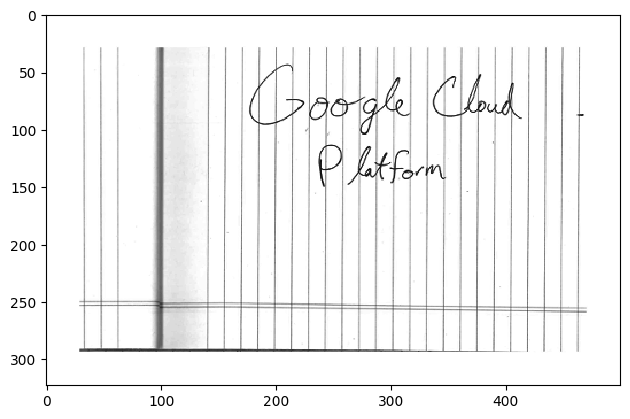

In [137]:
import matplotlib.pyplot as plt
from skimage import exposure, io
from skimage.transform import resize
from skimage.util import random_noise
from skimage.restoration import denoise_bilateral

img = io.imread("test1.png", as_gray=True)

# img = random_noise(img, mode='gaussian')
# img = denoise_bilateral(img)

img = exposure.adjust_gamma(img, 3)
img = exposure.adjust_log(img, 1)
io.imshow(img)
plt.imsave("test1-edited.png", img, cmap=plt.cm.gray)

img = open("test1-edited.png", "rb")


read_response = computervision_client.read_in_stream(
    image=img,
    mode="Printed",
    raw=True
)

operation_id = read_response.headers['Operation-Location'].split('/')[-1]
while True:
    read_result = computervision_client.get_read_result(operation_id)
    if read_result.status not in ['notStarted', 'running']:
        break
    time.sleep(1)

result = []
lines = []
if read_result.status == OperationStatusCodes.succeeded:
    for text_result in read_result.analyze_result.read_results:
        for line in text_result.lines:
            lines.append(line.text)
            for word in line.words:
                result.append(word.text)

print()
groundTruth = ["Google", "Cloud", "Platform"]
groundTruthLines = ["Google Cloud", "Platform"]

print()
print("Levenshtein distance: ")
print(f"CER: {cer(lines, groundTruthLines, lev_distance)}")
print(f"WER: {wer(result, groundTruth, lev_distance)}")

print()
print("Jaro-Winkler distance: ")
print(f"CER: {cer(lines, groundTruthLines, jaro_distance)}")
print(f"WER: {wer(result, groundTruth, jaro_distance)}")

Succes in resolvarea
TEMELOR la
LABORA toarele de
Inteligentà Artificialà!


Levenshtein distance: 
CER: 0.08695652173913043
WER: 0.6666666666666666

Jaro distance: 
CER: 0.057971014492753624
WER: 0.5555555555555556


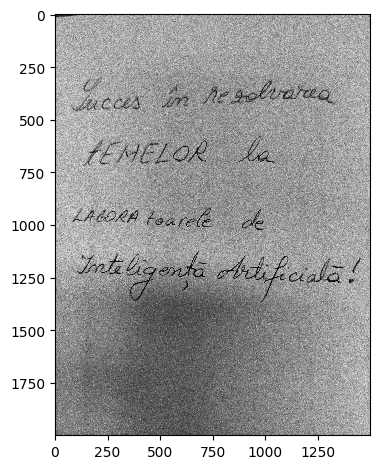

In [138]:
import matplotlib.pyplot as plt
from skimage import exposure, io
from skimage.restoration import denoise_bilateral


img = io.imread("test2.jpeg", as_gray=True)

img = random_noise(img, mode='gaussian')
img = denoise_bilateral(img)

img = exposure.adjust_gamma(img, 3)
img = exposure.adjust_log(img, 1)
io.imshow(img)
plt.imsave("test2-edited.jpeg", img, cmap=plt.cm.gray)

img = open("test2-edited.jpeg", "rb")

read_response = computervision_client.read_in_stream(
    image=img,
    mode="Printed",
    raw=True
)

operation_id = read_response.headers['Operation-Location'].split('/')[-1]
while True:
    read_result = computervision_client.get_read_result(operation_id)
    if read_result.status not in ['notStarted', 'running']:
        break
    time.sleep(1)

result = []
lines = []
if read_result.status == OperationStatusCodes.succeeded:
    for text_result in read_result.analyze_result.read_results:
        for line in text_result.lines:
            print(line.text)
            lines.append(line.text)
            for word in line.words:
                result.append(word.text)

print()
groundTruth = ["Succes", "in", "rezolvarea", "tEMELOR", "la", "LABORAtoarele",  "de", "Inteligenta", "Artificiala!"]
groundTruthLines = ["Succes in rezolvarea", "tEMELOR la", "LABORAtoaree de", "Inteligenta Artificiala!"]

print()
print("Levenshtein distance: ")
print(f"CER: {cer(lines, groundTruthLines, lev_distance)}")
print(f"WER: {wer(result, groundTruth, lev_distance)}")

print()
print("Jaro distance: ")
print(f"CER: {cer(lines, groundTruthLines, jaro_distance)}")
print(f"WER: {wer(result, groundTruth, jaro_distance)}")